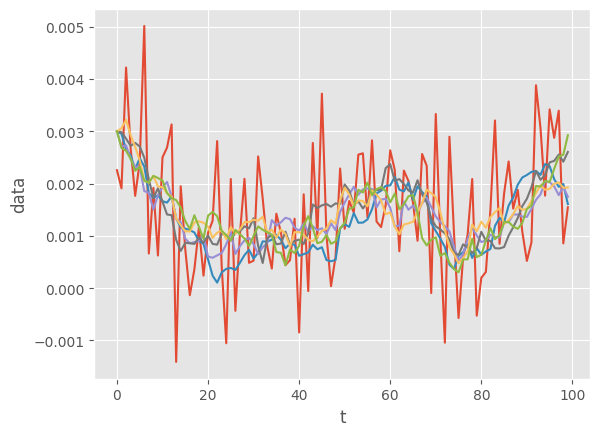

In [87]:
#%pip install particles
#%pip install seaborn

# the usual imports
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

# imports from the package
import particles
from particles import state_space_models as ssm
from particles import distributions as dists
from particles.collectors import Moments


class TwoStateTest(ssm.StateSpaceModel):
    """ Theta-Logistic state-space model (used in Ecology).
    """
    default_params = {'sigmaX': 2.e-4,
                      'sigmaY': 1e-3,
                      'x0': np.array([3e-3, -3e-3])
                     }


    def PX0(self):
        return dists.Dirac(loc=self.x0[0])

    def PX(self, t, xp):  #  Distribution of X_t given X_{t-1} = xp (p=past)
        return dists.Normal(loc=xp, scale=self.sigmaX)
                               

    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x, and X_{t-1}=xp
        return dists.Normal(loc=x, scale=self.sigmaY)
    
my_ssm = TwoStateTest()  # use default values for all parameters
x, y = my_ssm.simulate(100)


plt.style.use('ggplot')
plt.plot(y)
plt.xlabel('t')
plt.ylabel('data');


fk_boot = ssm.Bootstrap(ssm=my_ssm, data=y)

alg = particles.SMC(fk=fk_boot, N=100, qmc=False, resampling='systematic', ESSrmin=0.5,
                    store_history=True, verbose=False, collect=None)

alg.run()

trajectories = alg.hist.backward_sampling_ON2(5)
plt.plot(trajectories);
plt.show()



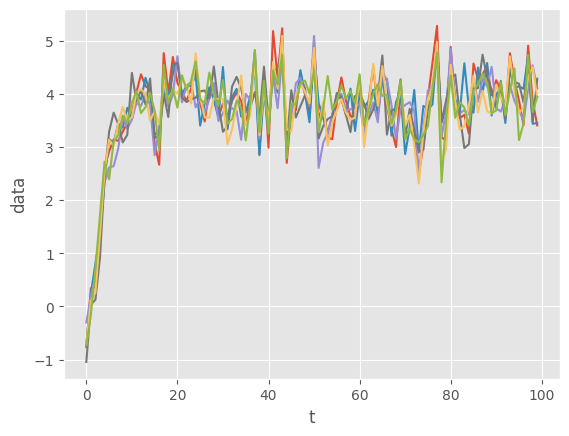

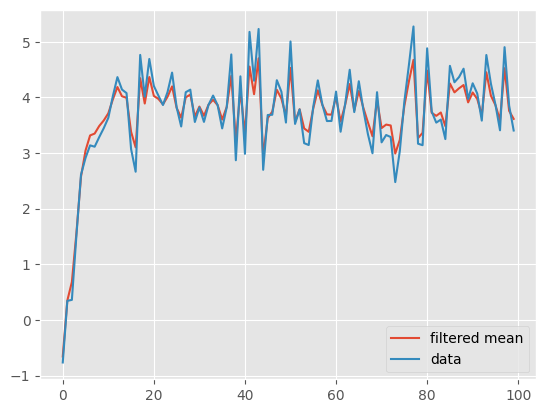

In [88]:
# the usual imports
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

# imports from the package
import particles
from particles import state_space_models as ssm
from particles import distributions as dists


class ThetaLogistic(ssm.StateSpaceModel):
    """ Theta-Logistic state-space model (used in Ecology).
    """
    default_params = {'tau0':1, 'tau1':.02, 'tau2':1, 'sigmaX': 0.47, 'sigmaY': 0.39}

    def PX0(self):  # Distribution of X_0
        return dists.Normal()

    def f(self, x):
        return (x + self.tau0 - self.tau1 * np.exp(self.tau2 * x))

    def PX(self, t, xp):  #  Distribution of X_t given X_{t-1} = xp (p=past)
        return dists.Normal(loc=self.f(xp), scale=self.sigmaX)

    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x, and X_{t-1}=xp
        return dists.Normal(loc=x, scale=self.sigmaY)
    
my_ssm = ThetaLogistic()  # use default values for all parameters
x, y = my_ssm.simulate(100)

plt.style.use('ggplot')
plt.plot(y)
plt.xlabel('t')
plt.ylabel('data')

fk_boot = ssm.Bootstrap(ssm=my_ssm, data=y)

from particles.collectors import Moments

alg_with_mom = particles.SMC(fk=fk_boot, N=1000, collect=[Moments()],store_history=True)
alg_with_mom.run()

trajectories = alg_with_mom.hist.backward_sampling_ON2(5)
plt.plot(trajectories)
plt.show()

plt.plot([m['mean'] for m in alg_with_mom.summaries.moments],
         label='filtered mean')
plt.plot(y, label='data')
plt.legend()
